In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'julia'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Inputs 
z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.75, 1.0, 11)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.775, 1.0, 10)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.675, 1.0, 14)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444

### Compute trajectories

In [4]:
# Compute trajectories for (z-TS) sweep 
if False:
        
    for ac_name in ['stca', 'a10']:

        for case in ['V2', 'Vmax']:

            pyna_settings = pyna.load_settings(case_name=ac_name)
            pyna_settings.ac_name = ac_name
            pyna_settings.engine_file_name = 'engine_deck_' + ac_name + '.csv'
            pyna_settings.save_results = True
            pyna_settings.output_directory_name = 'STCB/' + case
            pyna_settings.max_iter = 300
            pyna_settings.TS_to = 1.0
            pyna_settings.TS_vnrs = 1.0
            pyna_settings.PKROT = True

            pyna_settings.theta_flaps = 10.
            if ac_name == 'stca':
                pyna_settings.theta_slats = -6.
            elif ac_name == 'a10':
                # pyna_settings.theta_slats = 0
                pyna_settings.theta_slats = -6

            for j,TS in enumerate(TS_cb_lst[ac_name][case]):
                for i, z_cb in enumerate(z_cb_lst):

                    print("TS: ", TS)
                    print("z_cb:", z_cb)

                    pyna_settings.TS_cutback = TS
                    pyna_settings.z_cutback = z_cb
                    pyna_settings.output_file_name = pyna_settings.ac_name + '_' + str(np.round(z_cb,3)) + '_' + str(np.round(TS,3)) + '.sql'
                    
                    # Compute trajectory
                    py = pyna(pyna_settings)
                    py.ac.v_max = Vmax_lst[ac_name][case]
                                        
                    converged = py.compute_trajectory(trajectory_mode='cutback', objective='t_end')

                    # Save timeseries
                    path_save_name = 'trajectory_' + py.settings.ac_name + '_' + str(np.round(z_cb,3)) + '_' + str(np.round(TS,3)) + '.csv'
                    engine_save_name = 'engine_' + py.settings.ac_name + '_' + str(np.round(z_cb,3)) + '_' + str(np.round(TS,3)) + '.csv'
                    py.save_time_series(py.problem, py.settings, py.ac, path_save_name, engine_save_name)
                    
                    clear_output()

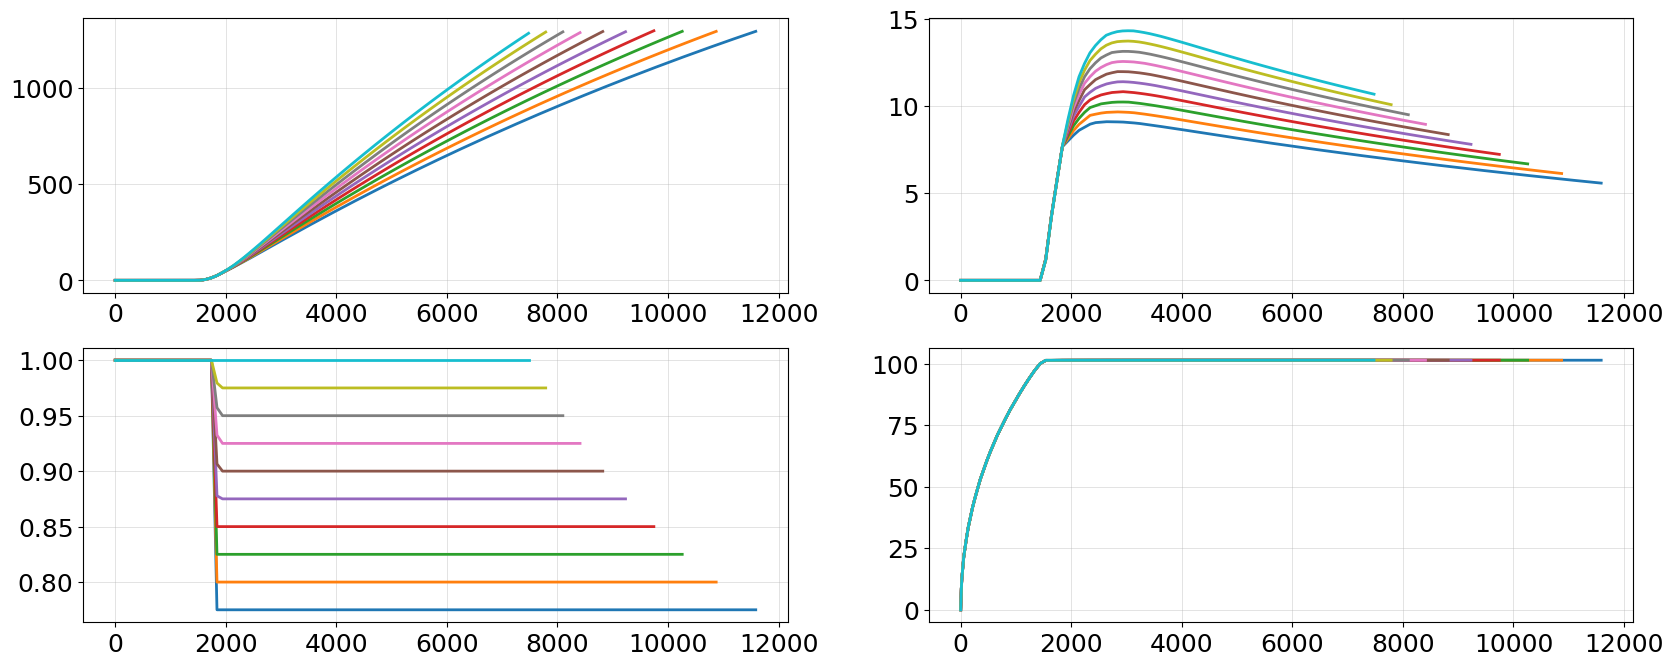

In [13]:
# Plot trajectories 
if False: 
    ac_name = 'stca'
    case = 'V2'
    
    pyna_settings = pyna.load_settings(case_name=ac_name)
    pyna_settings.ac_name = ac_name

    fig, ax = plt.subplots(2, 2, figsize=(20,8))
    plt.style.use('../utils/plot.mplstyle')

    for j,TS in enumerate(TS_cb_lst[ac_name][case][1:]):
        for i, z_cb in enumerate([z_cb_lst[0]]):

            pyna_settings.output_file_name = pyna_settings.ac_name + '_' + str(np.round(z_cb,2)) + '_' + str(np.round(TS,2)) + '.sql'

            pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_' + str(np.round(z_cb,2)) + '_' + str(np.round(TS,2)) + '.csv'
            pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_' + str(np.round(z_cb,2)) + '_' + str(np.round(TS,2)) + '.csv'

            data = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'_new/'+pyna_settings.trajectory_file_name)

            ax[0, 0].plot(data['X [m]'], data['Z [m]'])
            ax[1, 0].plot(data['X [m]'], data['TS [-]'])
            ax[0, 0].grid(True)
            ax[1, 0].grid(True)

            ax[0, 1].plot(data['X [m]'], data['gamma [deg]'])
            ax[1, 1].plot(data['X [m]'], data['V [m/s]'])
            ax[0, 1].grid(True)
            ax[1, 1].grid(True)

### Compute certificatoin noise levels

In [3]:
# Compute noise time series
if True:
        
    for ac_name in ['stca', 'a10']:

        for case in ['V2', 'Vmax']:
            
            n_sl = 121
            epnl_sideline = np.zeros((np.size(z_cb_lst), np.size(TS_cb_lst[ac_name][case]), n_sl))
            epnl_lateral = np.zeros((np.size(z_cb_lst), np.size(TS_cb_lst[ac_name][case])))
            epnl_flyover = np.zeros((np.size(z_cb_lst), np.size(TS_cb_lst[ac_name][case])))
            
            pyna_settings = pyna.load_settings(case_name=ac_name)
            pyna_settings.ac_name = ac_name
            pyna_settings.output_directory_name = 'STCB/' + case
            
            for j,TS in enumerate(TS_cb_lst[ac_name][case]):
                for i, z_cb in enumerate(z_cb_lst):

                    print(ac_name, " ", case, " - TS: ", TS, "; z_cb: ", z_cb)

                    pyna_settings.TS_cutback = TS
                    pyna_settings.z_cutback = z_cb
                    pyna_settings.output_file_name = pyna_settings.ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.sql'
                    pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.csv'
                    pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.csv'

                    pyna_settings.observer_lst = ['contours',]

                    x_observer_lst = np.zeros((n_sl+1, 3))
                    x_observer_lst[:-1, 0] = np.linspace(0, 6500, n_sl)
                    x_observer_lst[:-1, 1] = 450*np.ones(n_sl)
                    x_observer_lst[:, 2] = 4*0.3048*np.ones(n_sl+1)
                    x_observer_lst[-1,0] = 6500.

                    pyna_settings.x_observer_array = x_observer_lst

                    py = pyna(pyna_settings)
                    py.compute_noise_time_series()

                    epnl_sideline[i,j,:] = py.problem.get_val('noise.epnl')[:-1]
                    epnl_lateral[i,j] = np.max(py.problem.get_val('noise.epnl')[:-1])
                    epnl_flyover[i,j] = py.problem.get_val('noise.epnl')[-1]

            np.save('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps/epnl_lateral.npy', epnl_lateral)
            np.save('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps/epnl_flyover.npy', epnl_flyover)
            np.save('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps/epnl_sideline.npy', epnl_sideline)

            clear_output()

### Extract properties of the trajectories

In [ ]:
# Compute noise time series
if False:
    
    k_rot_lst = dict()
    LD_climbout = dict()
    
    for ac_name in ['stca', 'a10']:

        k_rot_lst[ac_name] = dict()
        LD_climbout[ac_name] = dict()
        
        for case in ['V2', 'Vmax']:
            
            k_rot_lst[ac_name][case] = np.zeros((np.size(z_cb_lst), np.size(TS_cb_lst[ac_name][case])))
            LD_climbout[ac_name][case] = np.zeros((np.size(z_cb_lst), np.size(TS_cb_lst[ac_name][case])))
            
            pyna_settings = pyna.load_settings(case_name=ac_name)
            pyna_settings.output_directory_name = 'STCB/' + case
            pyna_settings.output_file_name = pyna_settings.ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.sql'
            pyna_settings.ac_name = ac_name
            
            for j,TS in enumerate(TS_cb_lst[ac_name][case]):
                for i, z_cb in enumerate(z_cb_lst):

                    print(ac_name, " ", case, " - TS: ", TS, "; z_cb: ", z_cb)

                    py = pyna(pyna_settings)
                    py.load_results(pyna_settings.output_file_name)
                    
                    k_rot_lst[ac_name][case][i,j] = py.problem.get_val('phases.groundroll.parameters:k_rot')
                    LD_climbout[ac_name][case][i,j] = py.problem.get_val('phases.groundroll.parameters:k_rot')

            np.save('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps/k_rot.npy', k_rot_lst[ac_name][case])
            np.save('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps/LD_climbout.npy', LD_climbout[ac_name][case])

            clear_output()